In [1]:
from symred.projection import (
    S3_projection, QubitTapering, CS_VQE_LW, 
    StabilizerIdentification, ObservableBiasing, stabilizer_walk
)
from symred.symplectic import *
from symred.utils import exact_gs_energy
from symred.utils import gf2_gaus_elim, gf2_basis_for_gf2_rref
from symred.chem import geometry_from_pubchem, MoleculeBuilder
from matplotlib import pyplot as plt
from functools import reduce
import json

In [2]:
with open('data/molecule_data.json', 'r') as jfile:
    molecule_geometries = json.load(jfile)
with open('data/score_data.json', 'r') as infile:
    scoring_data = json.load(infile)

molecules = [speciesname for speciesname in molecule_geometries.keys() 
             if (speciesname in scoring_data and
                 scoring_data[speciesname]['n_qubits_pre_taper']<100# and
                 #speciesname.find('+')==-1 and
                 #speciesname.find('-')==-1 and
                 #speciesname.find('SINGLET')!=-1
                )
            ]
print(molecules)

['H2O_STO-3G_SINGLET', 'BeH+_STO-3G_SINGLET', 'LiH_STO-3G_SINGLET', 'HF_STO-3G_SINGLET', 'BeH2_STO-3G_SINGLET', 'Be_STO-3G_SINGLET', 'HCl_STO-3G_SINGLET', 'NH3_STO-3G_SINGLET', 'F2_STO-3G_SINGLET', 'HCN_STO-3G_SINGLET', 'CH4_STO-3G_SINGLET', 'CH3NHCH3_STO-3G_SINGLET', 'CH3CH2NH2_STO-3G_SINGLET', 'CH3CH2OH_STO-3G_SINGLET', 'CH3OH_STO-3G_SINGLET', 'C2H6_STO-3G_SINGLET', 'CH3CN_STO-3G_SINGLET', 'CH3CHO_STO-3G_SINGLET', 'CH3CHOHCH3_STO-3G_SINGLET', 'CHONH2_STO-3G_SINGLET', 'CH3OCH3_STO-3G_SINGLET', 'C2H5F_STO-3G_SINGLET', 'CH3COCH3_STO-3G_SINGLET', 'CO2_STO-3G_SINGLET', 'O2_STO-3G_SINGLET', 'O3_STO-3G_SINGLET', 'HOOH_STO-3G_SINGLET', 'NaCl_STO-3G_SINGLET', 'H2S_STO-3G_SINGLET', 'SiH4_STO-3G_SINGLET']


# Build the molecule and its Hamiltonian with the Coupled-Cluster operator 

In [3]:
def build_mol(speciesname, fci=True):
    #print(speciesname in scoring_data)
    mol_data = molecule_geometries[speciesname]
    if 'name' in mol_data:
        print(mol_data['name'])

    atoms  = mol_data['atoms']
    coords = mol_data['coords']
    basis  = mol_data['basis'] #'6-31g' #'cc-pVDZ' #
    spin   = mol_data['multiplicity']
    charge = mol_data['charge']
    geometry = list(zip(atoms, coords))
    molecule = MoleculeBuilder(geometry=geometry, charge=charge, basis=basis, run_fci=fci)
    return molecule

# Set molecule parameters
speciesname = 'H2O_STO-3G_SINGLET'
molecule = build_mol(speciesname)

Molecule geometry:
O	0	0	0
H	0.952519	0	0
H	-0.246530058	0.9200627021	0

HF converged?   True
CCSD converged? True
FCI converged?  True

HF energy:   -74.96203967838716
MP2 energy:  -74.99708201366191
CCSD energy: -75.01073164269066
FCI energy:  -75.01084664816942


Number of qubits: 14


Molecular orbital energies:


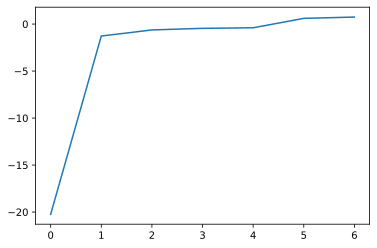

In [4]:
print('Molecular orbital energies:')
plt.plot(molecule.pyscf_obj.pyscf_hf.mo_energy)
plt.show()

# Taper the Hamiltonian

In [5]:
def taper_ham(molecule):
    taper_hamiltonian = QubitTapering(molecule.H_q)

    print(f'We are able to taper {taper_hamiltonian.n_taper} qubits from the Hamiltonian.\n')
    print('The symmetry generators are\n')
    print(taper_hamiltonian.symmetry_generators)
    print('\nand may be rotated via a sequence of Clifford pi/2 rotations\n')
    print(taper_hamiltonian.stabilizers.stabilizer_rotations)
    print('\nonto the single-qubit Pauli operators\n')
    print(taper_hamiltonian.stabilizers.rotate_onto_single_qubit_paulis())
    hf_array = molecule.H_fermion.hf_comp_basis_state
    taper_hamiltonian.stabilizers.update_sector(hf_array)
    print(f'\nThe symetry sector corresponding with the reference {hf_array} is {taper_hamiltonian.stabilizers.coeff_vec}')
    ham_tap = taper_hamiltonian.taper_it(ref_state=hf_array)
    #sor_tap = taper_hamiltonian.taper_it(aux_operator=sor_ham, ref_state=hf_array)
    #sor_tap.coeff_vec/=np.linalg.norm(sor_tap.coeff_vec)
    ucc_tap = taper_hamiltonian.taper_it(aux_operator=molecule.T_q, ref_state=hf_array)
    n_taper = taper_hamiltonian.n_taper
    tapered_qubits   = taper_hamiltonian.stab_qubit_indices
    untapered_qubits = taper_hamiltonian.free_qubit_indices
    hf_tapered = taper_hamiltonian.tapered_ref_state
    print(f'The tapered Hartree-Fock state is', QuantumState([hf_tapered]))
    return ham_tap, ucc_tap, hf_tapered

ham_tap, ucc_tap, hf_tapered = taper_ham(molecule)

We are able to taper 4 qubits from the Hamiltonian.

The symmetry generators are

 1 ZIZIIZZIIZZIIZ 
 1 IZIZIZIZIZIZIZ 
 1 IIIIZZIIIIIIZZ 
 1 IIIIIIIIZZIIII

and may be rotated via a sequence of Clifford pi/2 rotations

[(1.000+0.000j IIIIIIIIYZIIII, None), (1.000+0.000j IIIIYZIIIIIIZZ, None), (1.000+0.000j YIZIIZZIIZZIIZ, None), (1.000+0.000j IYIZIZIZIZIZIZ, None)]

onto the single-qubit Pauli operators

-1 XIIIIIIIIIIIII 
-1 IXIIIIIIIIIIII 
-1 IIIIXIIIIIIIII 
-1 IIIIIIIIXIIIII

The symetry sector corresponding with the reference [1 1 1 1 1 1 1 1 1 1 0 0 0 0] is [-1 -1  1  1]
The tapered Hartree-Fock state is  1.0000000000 |1111110000>


/home/tim/anaconda3/lib/python3.7/site-packages/symred/symplectic/stabilizerop.py:43: ComplexWarning: Casting complex values to real discards the imaginary part
  self.coeff_vec = self.coeff_vec.astype(int)


# Build the CS-VQE model

In [6]:
cs_vqe = CS_VQE_LW(ham_tap, hf_tapered, basis_weighting_operator=ucc_tap)

# Identify stabilizers according to the CC operator

In [24]:
max_sim_q = 14
def score_CC_generated_stabilizers(max_sim_q=max_sim_q):
    scores = []

    for i in range(1, ham_tap.n_qubits):
        CC_stabilizers = StabilizerIdentification(ucc_tap)
        S_CC           = CC_stabilizers.symmetry_basis_by_subspace_dimension(i)
        stab_score_CC  = cs_vqe.basis_score(S_CC)
        if i <= max_sim_q:
            ham_cs = cs_vqe.project_onto_subspace(S_CC)
            matrix = ham_cs.to_sparse_matrix
            cs_energy = exact_gs_energy(matrix)[0]
            error = cs_energy-molecule.fci_energy
            print(f'{i}-qubit CS-VQE error w.r.t. CCSD is {error:.5f} with stabilizer score {stab_score_CC:.5f}')
        else:
            cs_energy = None
            print(f'{i}-qubit CS-VQE energy not computed - stabilizer score {stab_score_CC:.5f}')

        scores.append((stab_score_CC, cs_energy))
        
    return scores

scores = score_CC_generated_stabilizers()

1-qubit CS-VQE error w.r.t. CCSD is 0.03086 with stabilizer score 0.33311
2-qubit CS-VQE error w.r.t. CCSD is 0.01422 with stabilizer score 0.66622
3-qubit CS-VQE error w.r.t. CCSD is 0.00033 with stabilizer score 0.99933
4-qubit CS-VQE error w.r.t. CCSD is 0.00018 with stabilizer score 0.99966


/home/tim/anaconda3/lib/python3.7/site-packages/symred/symplectic/stabilizerop.py:43: ComplexWarning: Casting complex values to real discards the imaginary part
  self.coeff_vec = self.coeff_vec.astype(int)


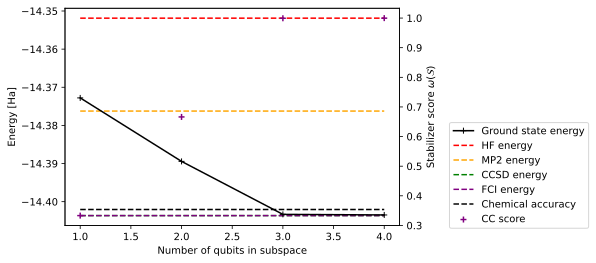

In [25]:
fig,energy_axis = plt.subplots()
X = np.arange(1, ham_tap.n_qubits)
Y_score,Y_energy = zip(*scores)

energy_axis.plot(X[:max_sim_q], Y_energy[:max_sim_q], color='black', marker='+', label='Ground state energy')
energy_axis.hlines(molecule.hf_energy, 1, X[-1], ls='--', color='red', label='HF energy')
energy_axis.hlines(molecule.mp2_energy, 1, X[-1], ls='--', color='orange', label='MP2 energy')
energy_axis.hlines(molecule.ccsd_energy, 1, X[-1], ls='--', color='green', label='CCSD energy')
if molecule.fci_energy is not None:
    energy_axis.hlines(molecule.fci_energy, 1, X[-1], ls='--', color='purple', label='FCI energy')
    energy_axis.hlines(molecule.fci_energy+0.0016, 1, X[-1], ls='--', color='black', label='Chemical accuracy')

#energy_axis.set_yscale('log')
energy_axis.set_ylabel('Energy [Ha]')
energy_axis.set_xlabel('Number of qubits in subspace')

score_axis = energy_axis.twinx()
score_axis.scatter(X, Y_score, color='purple', label='CC score', marker='+')

score_axis.set_ylabel('Stabilizer score $\omega(\mathcal{S})$')

fig.legend(ncol=1, bbox_to_anchor=(1.35,0.5))
plt.show()

# Run over the full molecule suite

In [45]:
molecules[::-1][:12]

['SiH4_STO-3G_SINGLET',
 'H2S_STO-3G_SINGLET',
 'NaCl_STO-3G_SINGLET',
 'HOOH_STO-3G_SINGLET',
 'O3_STO-3G_SINGLET',
 'O2_STO-3G_SINGLET',
 'CO2_STO-3G_SINGLET',
 'CH3COCH3_STO-3G_SINGLET',
 'C2H5F_STO-3G_SINGLET',
 'CH3OCH3_STO-3G_SINGLET',
 'CHONH2_STO-3G_SINGLET',
 'CH3CHOHCH3_STO-3G_SINGLET']

In [40]:
molecules[18:]

['CH3CHOHCH3_STO-3G_SINGLET',
 'CHONH2_STO-3G_SINGLET',
 'CH3OCH3_STO-3G_SINGLET',
 'C2H5F_STO-3G_SINGLET',
 'CH3COCH3_STO-3G_SINGLET',
 'CO2_STO-3G_SINGLET',
 'O2_STO-3G_SINGLET',
 'O3_STO-3G_SINGLET',
 'HOOH_STO-3G_SINGLET',
 'NaCl_STO-3G_SINGLET',
 'H2S_STO-3G_SINGLET',
 'SiH4_STO-3G_SINGLET']

In [ ]:
#score_data_2 = {}
with open('data/score_data_2.json', 'r') as infile:
    score_data_2 = json.load(infile)
        
for speciesname in molecules[::-1][:12]:
    print(f'Currently on {speciesname}')
    print()
    if scoring_data[speciesname]['n_qubits_pre_taper']<=30:
        fci_flag = True
        max_sim_q = 15
    else:
        fci_flag = False
        max_sim_q = 0
    molecule = build_mol(speciesname, fci=fci_flag)
    ham_tap, ucc_tap, hf_tapered = taper_ham(molecule)
    cs_vqe = CS_VQE_LW(ham_tap, hf_tapered, basis_weighting_operator=ucc_tap)
    try:
        scores, energies = zip(*score_CC_generated_stabilizers(max_sim_q=max_sim_q))

        score_data_2[speciesname] = {
            'n_qubits_pre_taper': int(molecule.n_qubits),
            'n_qubits_post_taper': int(ham_tap.n_qubits),
            'hf_energy': molecule.hf_energy,
            'mp2_energy': molecule.mp2_energy,
            'ccsd_energy': molecule.ccsd_energy,
            'fci_energy': molecule.fci_energy,
            'cs_vqe_energies': energies,
            'stabilizer_score': scores
        }

        with open('data/score_data_2.json', 'w') as outfile:
            json.dump(score_data_2, outfile)
    except:
        print('Something went wrong!')
        
    print()
    print('-'*100)
    print('-'*100)
    print()

Currently on SiH4_STO-3G_SINGLET

silane
Molecule geometry:
Si	0.0	0.0	0.0
H	0.8544	0.8544	0.8544
H	-0.8544	-0.8544	0.8544
H	-0.8544	0.8544	-0.8544
H	0.8544	-0.8544	-0.8544

HF converged?   True
CCSD converged? True
FCI converged?  True

HF energy:   -287.9102132258576
MP2 energy:  -287.9599882077337
CCSD energy: -287.9833192736758
FCI energy:  -287.9840018942706


Number of qubits: 26


/home/tim/anaconda3/lib/python3.7/site-packages/symred/symplectic/stabilizerop.py:43: ComplexWarning: Casting complex values to real discards the imaginary part
  self.coeff_vec = self.coeff_vec.astype(int)


We are able to taper 2 qubits from the Hamiltonian.

The symmetry generators are

 1 ZIZIZIZIZIZIZIZIZIZIZIZIZI 
 1 IZIZIZIZIZIZIZIZIZIZIZIZIZ

and may be rotated via a sequence of Clifford pi/2 rotations

[(1.000+0.000j YIZIZIZIZIZIZIZIZIZIZIZIZI, None), (1.000+0.000j IYIZIZIZIZIZIZIZIZIZIZIZIZ, None)]

onto the single-qubit Pauli operators

-1 XIIIIIIIIIIIIIIIIIIIIIIIII 
-1 IXIIIIIIIIIIIIIIIIIIIIIIII

The symetry sector corresponding with the reference [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0] is [-1 -1]
The tapered Hartree-Fock state is  1.0000000000 |111111111111111100000000>
1-qubit CS-VQE error w.r.t. CCSD is 0.06837 with stabilizer score 0.08107
2-qubit CS-VQE error w.r.t. CCSD is 0.06366 with stabilizer score 0.15128
3-qubit CS-VQE error w.r.t. CCSD is 0.06141 with stabilizer score 0.18491
4-qubit CS-VQE error w.r.t. CCSD is 0.05918 with stabilizer score 0.23072
5-qubit CS-VQE error w.r.t. CCSD is 0.05652 with stabilizer score 0.28286
6-qubit CS-VQE error w.r.t. CCS

HF converged?   True
CCSD converged? True
FCI converged?  True

HF energy:   -148.76499659403453
MP2 energy:  -148.84191263715758
CCSD energy: -148.87058841186249
FCI energy:  -148.8713797551712


Number of qubits: 24
We are able to taper 3 qubits from the Hamiltonian.

The symmetry generators are

 1 ZIIZIZZIZIIZIZIZZIZIIZZI 
 1 IZIZIZIZIZIZIZIZIZIZIZIZ 
 1 IIZZZZIIIIZZZZZZIIIIZZII

and may be rotated via a sequence of Clifford pi/2 rotations

[(1.000+0.000j YIIZIZZIZIIZIZIZZIZIIZZI, None), (1.000+0.000j IIYZZZIIIIZZZZZZIIIIZZII, None), (1.000+0.000j IYIZIZIZIZIZIZIZIZIZIZIZ, None)]

onto the single-qubit Pauli operators

-1 XIIIIIIIIIIIIIIIIIIIIIII 
-1 IXIIIIIIIIIIIIIIIIIIIIII 
-1 IIXIIIIIIIIIIIIIIIIIIIII

The symetry sector corresponding with the reference [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0] is [-1 -1  1]
The tapered Hartree-Fock state is  1.0000000000 |111111111111111000000>
1-qubit CS-VQE error w.r.t. CCSD is 0.09873 with stabilizer score 0.05930
2-qubit CS-VQE error

HF converged?   True
CCSD converged? True
FCI converged?  True

HF energy:   -185.0652452304234
MP2 energy:  -185.26547775236594
CCSD energy: -185.2570088885767
FCI energy:  -185.2774161206821


Number of qubits: 30
We are able to taper 4 qubits from the Hamiltonian.

The symmetry generators are

 1 ZIIZIZIZZIIZIZIZZIZIZIIZIZIZZI 
 1 IZIZIZIZIZIZIZIZIZIZIZIZIZIZIZ 
 1 IIZZZZZZIIZZIIIIIIZZZZIIIIZZII 
 1 IIIIIIIIIIIIZZZZIIZZZZZZZZIIII

and may be rotated via a sequence of Clifford pi/2 rotations

[(1.000+0.000j IIIIIIIIIIIIYZZZIIZZZZZZZZIIII, None), (1.000+0.000j IIYZZZZZIIZZIIIIIIZZZZIIIIZZII, None), (1.000+0.000j YIIZIZIZZIIZIZIZZIZIZIIZIZIZZI, None), (1.000+0.000j IYIZIZIZIZIZIZIZIZIZIZIZIZIZIZ, None)]

onto the single-qubit Pauli operators

-1 XIIIIIIIIIIIIIIIIIIIIIIIIIIIII 
-1 IXIIIIIIIIIIIIIIIIIIIIIIIIIIII 
-1 IIXIIIIIIIIIIIIIIIIIIIIIIIIIII 
-1 IIIIIIIIIIIIXIIIIIIIIIIIIIIIII

The symetry sector corresponding with the reference [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 


Number of qubits: 40
We are able to taper 3 qubits from the Hamiltonian.

The symmetry generators are

 1 ZIZIZIZIZIZIIZZIZIIZZIIZZIZIIZZIZIZIZIIZ 
 1 IZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZ 
 1 IIIIIIIIIIIIZZIIIIZZIIZZIIIIZZIIIIIIIIZZ

and may be rotated via a sequence of Clifford pi/2 rotations

[(1.000+0.000j IIIIIIIIIIIIYZIIIIZZIIZZIIIIZZIIIIIIIIZZ, None), (1.000+0.000j YIZIZIZIZIZIIZZIZIIZZIIZZIZIIZZIZIZIZIIZ, None), (1.000+0.000j IYIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZ, None)]

onto the single-qubit Pauli operators

-1 XIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII 
-1 IXIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII 
-1 IIIIIIIIIIIIXIIIIIIIIIIIIIIIIIIIIIIIIIII

The symetry sector corresponding with the reference [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0] is [-1 -1  1]
The tapered Hartree-Fock state is  1.0000000000 |1111111111111111111111100000000000000>
1-qubit CS-VQE energy not computed - stabilizer score 0.03341
2-qubit CS-VQE energy not computed 

The tapered Hartree-Fock state is  1.0000000000 |111111111111111111111000000000000>
1-qubit CS-VQE energy not computed - stabilizer score 0.13085
2-qubit CS-VQE energy not computed - stabilizer score 0.18376
3-qubit CS-VQE energy not computed - stabilizer score 0.25876
4-qubit CS-VQE energy not computed - stabilizer score 0.37942
5-qubit CS-VQE energy not computed - stabilizer score 0.38657
6-qubit CS-VQE energy not computed - stabilizer score 0.41474
7-qubit CS-VQE energy not computed - stabilizer score 0.44503
8-qubit CS-VQE energy not computed - stabilizer score 0.46612
9-qubit CS-VQE energy not computed - stabilizer score 0.49317
10-qubit CS-VQE energy not computed - stabilizer score 0.49930
11-qubit CS-VQE energy not computed - stabilizer score 0.50491
12-qubit CS-VQE energy not computed - stabilizer score 0.51030
13-qubit CS-VQE energy not computed - stabilizer score 0.52197
14-qubit CS-VQE energy not computed - stabilizer score 0.53575
15-qubit CS-VQE energy not computed - stabi

In [120]:
scoring_data

{'HCN_STO-3G_SINGLET': {'n_qubits_pre_taper': 22,
  'n_qubits_post_taper': 19,
  'hf_energy': -91.67520896743609,
  'mp2_energy': -91.82881563197407,
  'ccsd_energy': -91.83755422811633,
  'fci_energy': -91.84091227095661,
  'cs_vqe_energies': [-91.70953562096278,
   -91.7438203260678,
   -91.76913120332726,
   -91.77801756187954,
   -91.7780197646298,
   -91.77836493938732,
   -91.78060697326073,
   -91.78481275462698,
   -91.78922649360682,
   -91.7948919589324,
   -91.7995279815709,
   -91.80703080159954,
   -91.81961757308859,
   -91.83854355791794,
   -91.84046631477197],
  'stabilizer_score': [0.4489609277838124,
   0.6349266330474751,
   0.7671839118493012,
   0.7997478738215654,
   0.8050721992355252,
   0.8120776053296211,
   0.8347397726650917,
   0.8525968526390996,
   0.8610030259675194,
   0.8712996825423301,
   0.8933730624120365,
   0.9107486987722309,
   0.9389440180985552,
   0.9908611681039793,
   0.9998570796182393,
   0.9998750536626938,
   0.9999612163923932,
   0.

In [16]:
from copy import deepcopy
cs_vqe_energies
stabilizer_score
scoring_data_2 = deepcopy(scoring_data)
scoring_data_2[speciesname]

{'n_qubits_pre_taper': 14,
 'n_qubits_post_taper': 10,
 'hf_energy': -74.96203967838726,
 'mp2_energy': -74.99708201366201,
 'ccsd_energy': -75.01073164269077,
 'fci_energy': -75.01084664816948,
 'cs_vqe_energies': [-74.97444018171565,
  -74.97444208385232,
  -74.97762590720568,
  -74.97870771628529,
  -74.98649588089906,
  -74.99507322860299,
  -75.00133795184789,
  -75.01076787407143,
  -75.01079397067357],
 'stabilizer_score': [0.5907886228629189,
  0.6076032695625551,
  0.6707198559522196,
  0.6999581284623866,
  0.791772891938128,
  0.8983334155684678,
  0.9402666655948168,
  0.9999538429324419,
  0.9999724151786065]}

In [15]:
with open('data/score_data_2.json', 'w') as outfile:
    json.dump(scoring_data_2, outfile)

In [13]:
scoring_data[speciesname]

{'n_qubits_pre_taper': 14,
 'n_qubits_post_taper': 10,
 'hf_energy': -74.96203967838726,
 'mp2_energy': -74.99708201366201,
 'ccsd_energy': -75.01073164269077,
 'fci_energy': -75.01084664816948,
 'cs_vqe_energies': [-74.97444018171565,
  -74.97444208385232,
  -74.97762590720568,
  -74.97870771628529,
  -74.98649588089906,
  -74.99507322860299,
  -75.00133795184789,
  -75.01076787407143,
  -75.01079397067357],
 'stabilizer_score': [0.5907886228629189,
  0.6076032695625551,
  0.6707198559522196,
  0.6999581284623866,
  0.791772891938128,
  0.8983334155684678,
  0.9402666655948168,
  0.9999538429324419,
  0.9999724151786065]}